Practice of fast ai - using cnn_learner for image classification, unet_learner for segmentation, text_classifier_learner for sentiment analysis, tabular_learner for decisiontree, collab_learner for ranking

In [ ]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 17.8MB/s 
     |████████████████████████████████| 194kB 58.5MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 1.2MB 23.9MB/s 
     |████████████████████████████████| 61kB 9.6MB/s 
Mounted at /content/gdrive


In [ ]:
#hide
from fastbook import *

Case 1:
Begin by training an image classifier to recognize dogs and cats

In [ ]:
#id first_training
#caption Results from the first training
# CLICK ME
from fastai.vision.all import *
path = untar_data(URLs.PETS)/'images'

def is_dog(x): return x[0].islower()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_dog, item_tfms=Resize(224))

learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.141307,0.026452,0.008119,00:49


epoch,train_loss,valid_loss,error_rate,time
0,0.054531,0.021254,0.008796,00:53


Upload a picture of dog, see notebook thinks it is a dog or a cat, and how confident it is


In [ ]:
#hide_output
uploader = widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

In [ ]:
#hide
# For the book, we can't actually click an upload button, so we fake it
uploader = SimpleNamespace(data = ['images/chapter1_cat_example.jpg'])

In [ ]:
img = PILImage.create(uploader.data[0])
is_cat,_,probs = learn.predict(img)
print(f"Is this a dog?: {is_dog}.")
print(f"Probability it's a dog: {probs[1].item():.6f}")

Is this a dog?: <function is_dog at 0x7f602de75d90>.
Probability it's a dog: 0.999111


Case 2:
Localizing objects in a picture. Creating a model that can recognize the content of every individual pixel in an image is called *segmentation*. Here is how we can train a segmentation model with fastai, using a subset of the [*Camvid* dataset](http://www0.cs.ucl.ac.uk/staff/G.Brostow/papers/Brostow_2009-PRL.pdf) from the paper "Semantic Object Classes in Video: A High-Definition Ground Truth Database" by Gabruel J. Brostow, Julien Fauqueur, and Roberto Cipolla:

In [ ]:
path = untar_data(URLs.CAMVID_TINY)
dls = SegmentationDataLoaders.from_label_func(
    path, bs=8, fnames = get_image_files(path/"images"),
    label_func = lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    codes = np.loadtxt(path/'codes.txt', dtype=str)
)

learn = unet_learner(dls, resnet34)
learn.fine_tune(8)

epoch,train_loss,valid_loss,time
0,3.202383,2.581477,00:01


epoch,train_loss,valid_loss,time
0,1.816497,1.492005,00:01
1,1.580009,1.184191,00:01
2,1.507038,1.276269,00:01
3,1.390453,0.966015,00:01
4,1.251380,0.781067,00:01
5,1.129896,0.729235,00:01
6,1.031254,0.710174,00:01
7,0.956234,0.696088,00:01


We can visualize how well it achieved its task, by asking the model to color-code each pixel of an image. As you can see, it nearly perfectly classifies every pixel in every object.

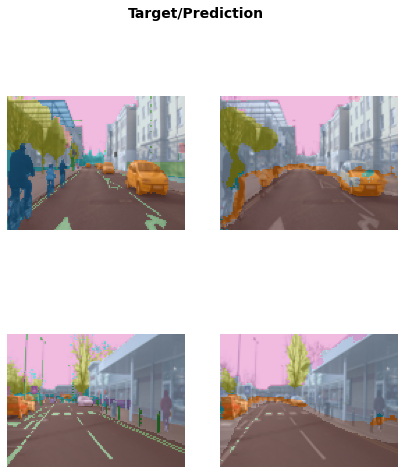

In [ ]:
learn.show_results(max_n=6, figsize=(7,8))

Case 3:
One other area where deep learning has dramatically improved in the last couple of years is natural language processing (NLP). 

Here is the code necessary to train a model that can classify the sentiment of a movie review 

In [ ]:
from fastai.text.all import *

dls = TextDataLoaders.from_folder(untar_data(URLs.IMDB), valid='test')
learn = text_classifier_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)
learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.462372,0.408912,0.815600,03:43


epoch,train_loss,valid_loss,accuracy,time
0,0.301575,0.288861,0.881280,07:43
1,0.244879,0.249279,0.899160,07:47
2,0.200392,0.184522,0.929000,07:46
3,0.148192,0.193559,0.929000,07:46


In [ ]:
learn.predict("Sorry, that's not quite right. This film is a stinking pile of crap.")

('neg', tensor(0), tensor([0.9987, 0.0013]))

Here we can see the model has considered the review to be negative. The second part of the result is the index of "neg" in our data vocabulary and the last part is the probabilities attributed to each class (98.92% for "pos" and 1.08% for "neg"). 

Case 4:
Here is a tabular case to train a model that will predict whether a person is a high-income earner, based on their socioeconomic background:

In [ ]:
from fastai.tabular.all import *
path = untar_data(URLs.ADULT_SAMPLE)

dls = TabularDataLoaders.from_csv(path/'adult.csv', path=path, y_names="salary",
    cat_names = ['workclass', 'education', 'marital-status', 'occupation',
                 'relationship', 'race'],
    cont_names = ['age', 'fnlwgt', 'education-num'],
    procs = [Categorify, FillMissing, Normalize])

learn = tabular_learner(dls, metrics=accuracy)

There is no pretrained model available for this task (in general, pretrained models are not widely available for any tabular modeling tasks, although some organizations have created them for internal use), so we don't use `fine_tune` in this case. Instead we use `fit_one_cycle`, the most commonly used method for training fastai models *from scratch* (i.e. without transfer learning):

In [ ]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,0.359432,0.364629,0.833231,00:05
1,0.343560,0.354028,0.840909,00:04
2,0.333736,0.348174,0.841984,00:05


This model is using the [*Adult* dataset](http://robotics.stanford.edu/~ronnyk/nbtree.pdf), from the paper "Scaling Up the Accuracy of Naive-Bayes Classifiers: a Decision-Tree Hybrid" by Rob Kohavi, which contains some demographic data about individuals (like their education, marital status, race, sex, and whether or not they have an annual income greater than \$50k). The model is over 80\% accurate, and took around 30 seconds to train.

Case 5:
Recommendation systems are very important, particularly in e-commerce. Companies like Amazon and Netflix try hard to recommend products or movies that users might like. Here's how to train a model that will predict movies people might like, based on their previous viewing habits.

In [ ]:
from fastai.collab import *
path = untar_data(URLs.ML_SAMPLE)
dls = CollabDataLoaders.from_csv(path/'ratings.csv')
learn = collab_learner(dls, y_range=(0.5,5.5))
learn.fine_tune(10)

epoch,train_loss,valid_loss,time
0,1.483265,1.437832,00:00


epoch,train_loss,valid_loss,time
0,1.357736,1.375661,00:00
1,1.267864,1.187500,00:00
2,1.028255,0.866223,00:00
3,0.808244,0.710072,00:00
4,0.700847,0.666740,00:00
5,0.651867,0.652857,00:00
6,0.631682,0.645315,00:00
7,0.621070,0.642045,00:00
8,0.610686,0.640849,00:00
9,0.626359,0.640692,00:00


This model is predicting movie ratings on a scale of 0.5 to 5.0 to within around 0.6 average error. Since we're predicting a continuous number, rather than a category, we have to tell fastai what range our target has, using the `y_range` parameter.

We can use the same `show_results` call we saw earlier to view a few examples of user and movie IDs, actual ratings, and predictions:

In [ ]:
learn.show_results()

,userId,movieId,rating,rating_pred
0,67.0,1.0,4.0,3.155321
1,64.0,55.0,5.0,4.354988
2,9.0,80.0,4.0,3.598868
3,27.0,70.0,4.0,3.564672
4,87.0,31.0,5.0,4.191054
5,88.0,45.0,4.0,4.125295
6,43.0,80.0,2.0,3.763496
7,62.0,58.0,3.5,3.889969
8,47.0,64.0,4.0,4.097356
